In [28]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from combine_models import KNNHateSpeechClassifier, LogisticHateSpeech, RidgeHateSpeechClassifier, LassoHateSpeechClassifier, NBHateSpeechClassifier, HateSpeechRFClassifier,HateSpeechXGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"


In [29]:
class StackedHateSpeechClassifier(BaseEstimator, ClassifierMixin):
    """
    Scikit-learn compatible stacked hate speech classifier using sentence-transformer embeddings.

    Args:
        threshold (float): Probability threshold for binary classification.
        model_name (str): SentenceTransformer model to use.
        precomputed (bool): Whether input to fit/predict is already embedded.
    """
    def __init__(self, threshold=0.25, model_name='all-MiniLM-L6-v2', precomputed=False, base_learners=None, meta_model=None):
        self.threshold = threshold
        self.model_name = model_name
        self.precomputed = precomputed

        self.embedder = SentenceTransformer(model_name)
        self.scaler = StandardScaler()

        # Initialize base learners without internal thresholding logic
        self.base_learners = base_learners if base_learners else [
        ('lr', LogisticHateSpeech(precomputed=True)),
        ('ridge', RidgeHateSpeechClassifier(precomputed=True)),
        ('lasso', LassoHateSpeechClassifier(precomputed=True)),
        ('rf', HateSpeechRFClassifier(precomputed=True)),
        ('knn', KNNHateSpeechClassifier(precomputed=True)),
        ('xgb', HateSpeechXGBClassifier(precomputed=True)),
        ('gnb', NBHateSpeechClassifier(precomputed=True))
        ]

        self.meta_model = meta_model if meta_model else LogisticRegression(random_state=42)
        self.stacked = StackingClassifier(estimators=self.base_learners, final_estimator=self.meta_model, cv=3, n_jobs=-1)

    def fit(self, X, y):
        if self.precomputed:
            X_scaled = self.scaler.fit_transform(X)
        else:
            X_emb = self.embedder.encode(X, show_progress_bar=False)
            X_scaled = self.scaler.fit_transform(X_emb)
        self.stacked.fit(X_scaled, y)
        return self

    def predict_proba(self, X):
        if self.precomputed:
            X_scaled = self.scaler.transform(X)
        else:
            X_emb = self.embedder.encode(X, show_progress_bar=False)
            X_scaled = self.scaler.transform(X_emb)
        return self.stacked.predict_proba(X_scaled)

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs[:, 1] >= self.threshold).astype(int)

    def score(self, X, y):
        return np.mean(self.predict(X) == np.array(y))

    def get_embeddings(self, texts, scale=True):
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()
        embeddings = self.embedder.encode(texts, show_progress_bar=False)
        if scale:
            return self.scaler.fit_transform(embeddings)
        return embeddings

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Not Hate", "Hate"],
                    yticklabels=["Not Hate", "Hate"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        plt.show()

    def show_misclassifications(self, X, y_true, y_pred):
        X = pd.Series(X)
        y_true = pd.Series(y_true)
        y_pred = pd.Series(y_pred)
        mismatches = X[y_true != y_pred]
        print("\nFALSE POSITIVES:")
        print(mismatches[(y_true == 0) & (y_pred == 1)].head(5).to_string(index=False))
        print("\nFALSE NEGATIVES:")
        print(mismatches[(y_true == 1) & (y_pred == 0)].head(5).to_string(index=False))

    def plot_roc_curve(self, X, y_true):
        probs = self.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y_true, probs)
        auc = roc_auc_score(y_true, probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve - Stacked Hate Speech Classifier")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def evaluate_base_models(self, X_test_scaled, y_test, threshold=0.5):
        print("Evaluating individual base models...\n")
        results = []

        for name, model in self.stacked.named_estimators_.items():
            if hasattr(model, "predict_proba"):
                probs = model.predict_proba(X_test_scaled)[:, 1]
            else:
                probs = model.decision_function(X_test_scaled)
                probs = (probs - probs.min()) / (probs.max() - probs.min())

            preds = (probs >= threshold).astype(int)
            auc = roc_auc_score(y_test, probs)
            f1 = f1_score(y_test, preds)

            results.append((name, auc, f1))
            print(f"Model: {name}")
            print(f"  AUC: {auc:.3f}")
            print(f"  F1 : {f1:.3f}\n")

        return sorted(results, key=lambda x: x[1], reverse=True)
    
    def get_params(self, deep=True):
        return {
            'threshold': self.threshold,
            'model_name': self.model_name,
            'precomputed': self.precomputed,
            'base_learners': self.base_learners,
            'meta_model': self.meta_model
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        # Reinitialize internal components if relevant params change
        if 'model_name' in params:
            self.embedder = SentenceTransformer(self.model_name)
        if 'base_learners' in params or 'meta_model' in params:
            self.stacked = StackingClassifier(
                estimators=self.base_learners,
                final_estimator=self.meta_model,
                cv=5,
                n_jobs=-1
            )
        return self


In [30]:
base_dir =  os.getcwd()
test_path = os.path.join(base_dir, "../data/test_data_clean.csv")
train_path = os.path.join(base_dir, "../data/train_data.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()
test_texts = test_df["comment"].tolist()
test_labels = test_df["isHate"].tolist()

In [31]:
model = StackedHateSpeechClassifier(precomputed=True)

X_train = model.get_embeddings(train_texts, scale=True)
X_test = model.scaler.transform(model.embedder.encode(test_texts))

pca = PCA(n_components=50)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)


param_grid = {'threshold': [0.2, 0.3, 0.4, 0.5, 0.6]}
custom_scorer = make_scorer(f1_score)

grid = GridSearchCV(
    estimator=StackedHateSpeechClassifier(precomputed=True),
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=3,
    error_score='raise'
)

grid.fit(X_train_reduced, train_labels)


best_model = grid.best_estimator_
optimal_threshold = grid.best_params_['threshold']
probs = best_model.predict_proba(X_test_reduced)[:, 1]
custom_preds = (probs >= optimal_threshold).astype(int)


test_labels_bin = np.array(test_labels)


print("Best Threshold:", optimal_threshold)
print(classification_report(test_labels_bin, custom_preds))



InvalidParameterError: The 'penalty' parameter of LogisticRegression must be a str among {'l2', 'l1', 'elasticnet'} or None. Got 'none' instead.

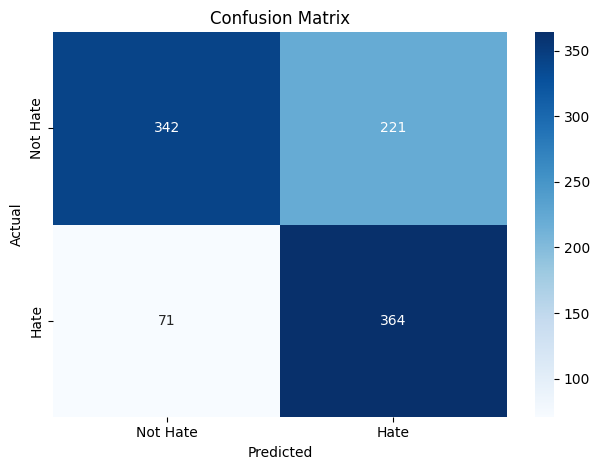


FALSE POSITIVES:
You look like someone who would do an electric ...
You can ask me to call you a male, but you'll a...
Yo, if I’m going to hell for being homosexual, ...
     White police officers are always the victims.
We need to exterminate people that subject chil...

FALSE NEGATIVES:
   You look like Sloth with deeper Down’s syndrome
Watching this kid trying to step up and walk wi...
                        U SUCK SHIT YOU BLACK FUCK
Throwing stones to paraplegic kids is my favour...
This sick, disgusting, white terrorist/fascist ...


In [ ]:
best_model.plot_confusion_matrix(test_labels_bin, custom_preds)
best_model.show_misclassifications(test_texts, test_labels_bin, custom_preds)



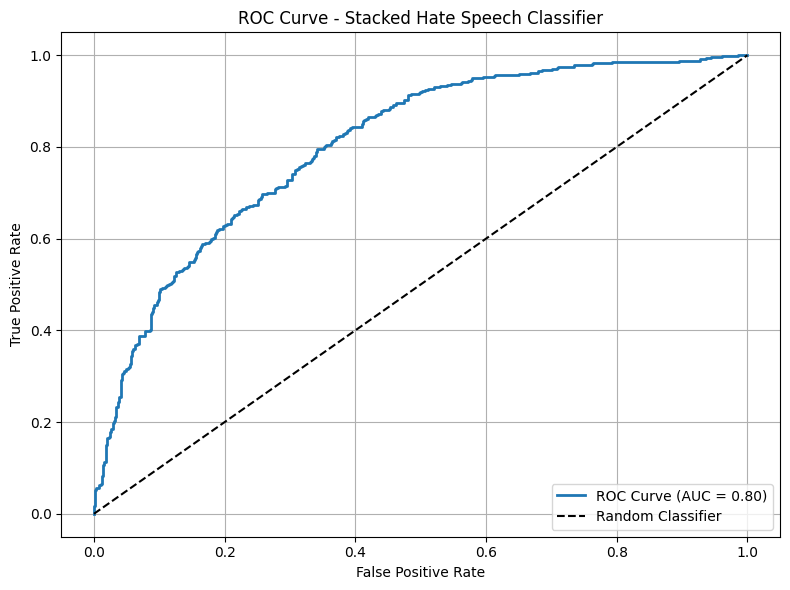

In [55]:
best_model.plot_roc_curve(X_test_reduced, test_labels_bin)

In [ ]:
results = best_model.evaluate_base_models(X_test_reduced, test_labels_bin, threshold=optimal_threshold)

Evaluating individual base models...

Model: lr
  AUC: 0.740
  F1 : 0.666

Model: rf
  AUC: 0.664
  F1 : 0.627

Model: knn
  AUC: 0.759
  F1 : 0.680

Model: xgb
  AUC: 0.765
  F1 : 0.676

Model: gnb
  AUC: 0.724
  F1 : 0.683



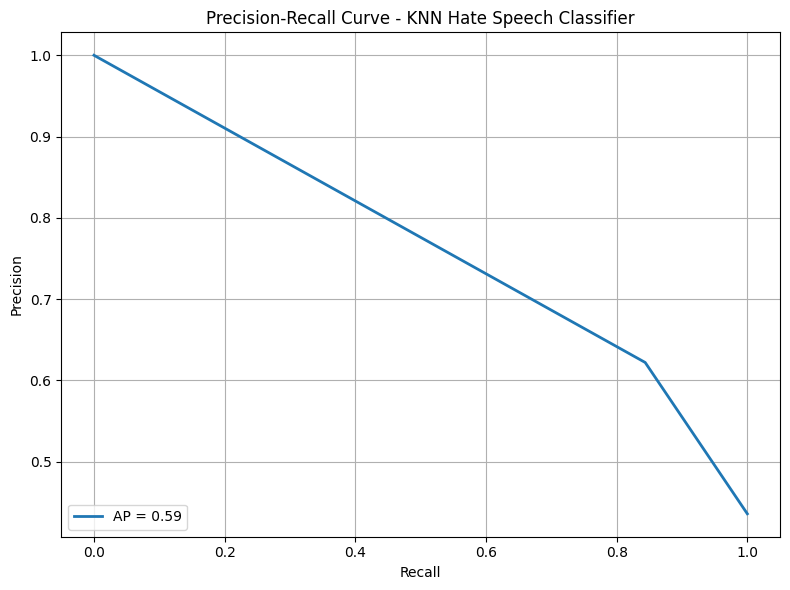

In [28]:
precision, recall, _ = precision_recall_curve(test_labels_bin, custom_preds)
avg_precision = average_precision_score(test_labels_bin, custom_preds)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - KNN Hate Speech Classifier')
plt.grid(True)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()